# Welcome to Norfolk Data Science

<img src="https://secure.meetupstatic.com/photos/event/c/f/b/a/highres_452453178.jpeg">

### Anomaly Detection
* 2017-09-05
* Christopher Brossman

# General Methods for Anomaly Detection
* Some threshold for deviation between expected and observed is surpassed. 
    * Requires labeled data and need to build model
* Completely automated systems which look for deviations
    * Time series models (we will cover [twitter's implementation in R](https://github.com/twitter/AnomalyDetection))
    * Multivariate models using one-class SVC (have implemented in R & python)

# Timeseries model using twitter's AnomalyDetection

In [44]:
# First read in some data
library('tidyverse')
cr_hour <- read_csv('crh.csv')
cr_hour <- cr_hour %>% 
  mutate(ds = as.POSIXct(timestamp), cr_scaled = cr*100000) %>% #scaling to better understand expected value later on
  filter(month == 8) %>% 
  select(ds,cr_scaled)
head(cr_hour)

Parsed with column specification:
cols(
  Date = col_character(),
  year = col_integer(),
  month = col_integer(),
  day = col_integer(),
  hr = col_integer(),
  timestamp = col_datetime(format = ""),
  cr = col_double()
)


ds,cr_scaled
2017-08-01 00:00:00,1000
2017-08-01 01:00:00,1000
2017-08-01 02:00:00,1000
2017-08-01 03:00:00,2000
2017-08-01 04:00:00,1000
2017-08-01 05:00:00,1000


# Lets look at the function

```AnomalyDetectionTs(x, max_anoms = 0.1, direction = "pos", alpha = 0.05,
  only_last = NULL, threshold = "None", e_value = FALSE,
  longterm = FALSE, piecewise_median_period_weeks = 2, plot = FALSE,
  y_log = FALSE, xlabel = "", ylabel = "count", title = NULL,
  verbose = FALSE)```
  
Arguments
* x : Time series as a two column data frame where the first column consists of the timestamps and the second column consists of the observations.
* max_anoms: Maximum number of anomalies that S-H-ESD will detect as a percentage of the data.
* direction: Directionality of the anomalies to be detected. Options are: 'pos' | 'neg' | 'both'.
* alpha: The level of statistical significance with which to accept or reject anomalies.
* only_last: Find and report anomalies only within the last day or hr in the time series. NULL | 'day' | 'hr'.
* threshold: Only report positive going anoms above the threshold specified. Options are: 'None' | 'med_max' | 'p95' | 'p99'.
* e_value:Add an additional column to the anoms output containing the expected value.
* longterm: Increase anom detection efficacy for time series that are greater than a month. See Details below.
* piecewise_median_period_weeks: The piecewise median time window as described in Vallis, Hochenbaum, and Kejariwal (2014). Defaults to 2.
* plot: A flag indicating if a plot with both the time series and the estimated anoms, indicated by circles, should also be returned.
* y_log: Apply log scaling to the y-axis. This helps with viewing plots that have extremely large positive anomalies relative to the rest of the data.
* xlabel: X-axis label to be added to the output plot.
* ylabel: Y-axis label to be added to the output plot.
* title: Title for the output plot.
* verbose: Enable debug messages

In [45]:
library(AnomalyDetection)
res = AnomalyDetectionTs(cr_hour, max_anoms=0.02, direction='both', 
                         plot=TRUE, e_value = TRUE,
                         xlabel = 'day', ylabel='Conversion Rate')

In [46]:
res$anoms

timestamp,anoms,expected_value
2017-08-01 10:00:00,4000,1823
2017-08-09 10:00:00,4000,1713
2017-08-28 04:00:00,3000,789


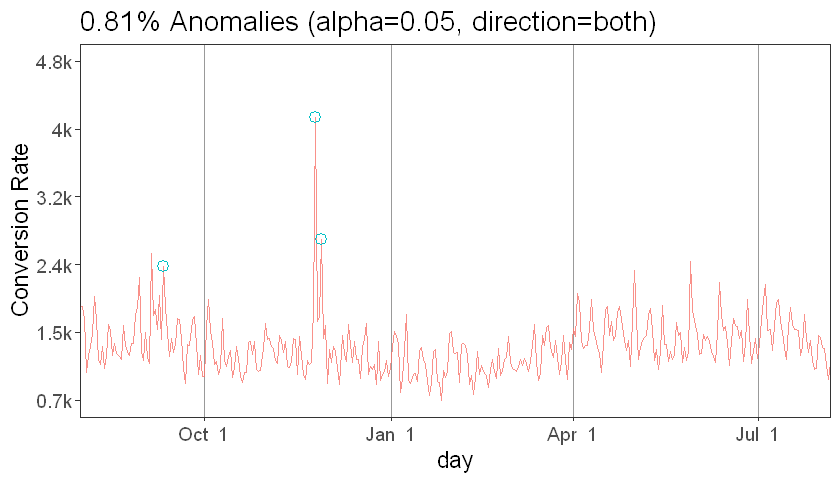

In [62]:
options(repr.plot.width=7, repr.plot.height=4)
res$plot

$anoms
data frame with 0 columns and 0 rows

$plot
NULL


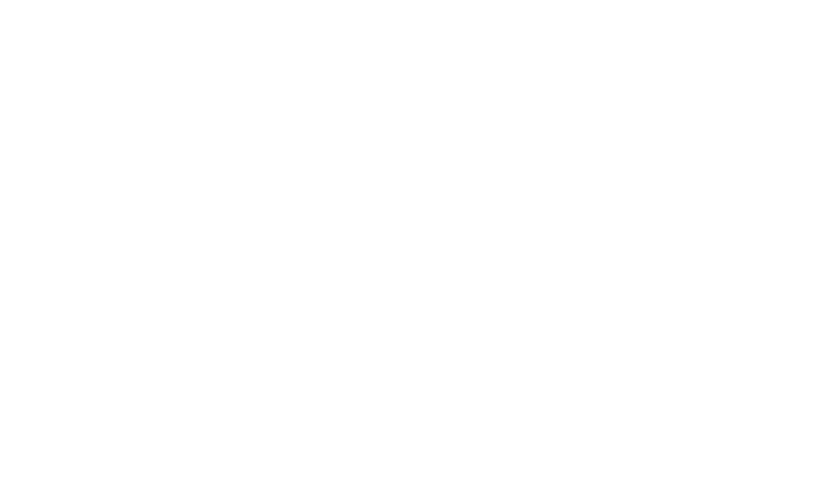

In [63]:
#wont always have an anomaly
library(AnomalyDetection)
res = AnomalyDetectionTs(cr_hour, max_anoms=0.02, direction='both', plot=TRUE, e_value = TRUE,
                         xlabel = 'day', ylabel='Conversion Rate',only_last='day')
res

Parsed with column specification:
cols(
  d = col_date(format = ""),
  cr = col_character()
)


$anoms
            timestamp    anoms expected_value
1 2016-09-10 20:00:00 2332.764           1591
2 2016-11-24 19:00:00 4157.531           1420
3 2016-11-27 19:00:00 2671.162           1877

$plot


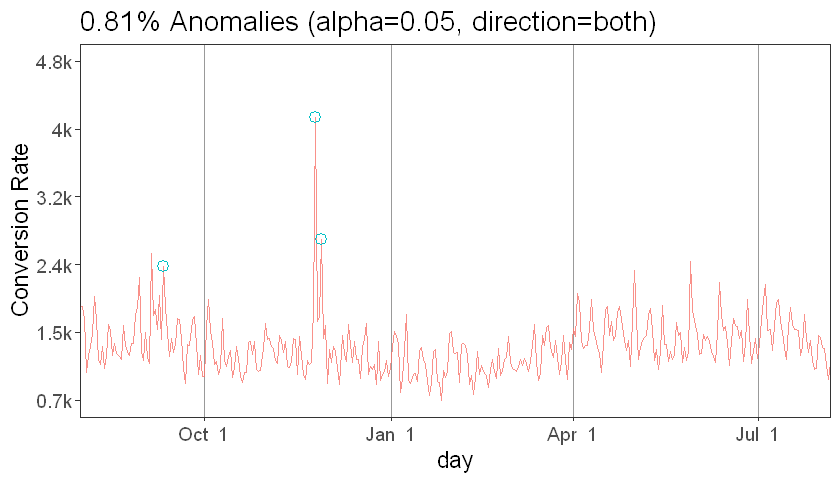

In [64]:
#lets see if it can detect a longer time period

cr_day <- read_csv('cr.csv')
cr_day <- cr_day %>% 
  mutate(d = as.POSIXct(d), cr = gsub('\t','',cr)) %>%
  mutate(cr_scaled = as.numeric(cr)*100000) %>% 
  select(d,cr_scaled)

library(AnomalyDetection)
res = AnomalyDetectionTs(cr_day, max_anoms=0.02, direction='both', plot=TRUE, e_value = TRUE,
                         xlabel = 'day', ylabel='Conversion Rate')
res

# Lets checkout a single class SVM for multivariate anomaly prediction

In [65]:
#lets look at the good old iris data set
library(e1071);
library(caret);
library(NLP);
library(tm);

data(iris)

#split to see how well the predictions work
iris$SpeciesClass[iris$Species=="versicolor"] <- "TRUE"
iris$SpeciesClass[iris$Species!="versicolor"] <- "FALSE"
trainPositive<-subset(iris,SpeciesClass=="TRUE")
testnegative<-subset(iris,SpeciesClass=="FALSE")
inTrain<-createDataPartition(1:nrow(trainPositive),p=0.6,list=FALSE)

#take only true predictors into a single DF
trainpredictors<-trainPositive[inTrain,1:4]
trainLabels<-trainPositive[inTrain,6]

testPositive<-trainPositive[-inTrain,]
testPosNeg<-rbind(testPositive,testnegative)

testpredictors<-testPosNeg[,1:4]
testLabels<-testPosNeg[,6]

#see what this looks like
print(head(iris))
print('')
print(head(trainpredictors))

  Sepal.Length Sepal.Width Petal.Length Petal.Width Species SpeciesClass
1          5.1         3.5          1.4         0.2  setosa        FALSE
2          4.9         3.0          1.4         0.2  setosa        FALSE
3          4.7         3.2          1.3         0.2  setosa        FALSE
4          4.6         3.1          1.5         0.2  setosa        FALSE
5          5.0         3.6          1.4         0.2  setosa        FALSE
6          5.4         3.9          1.7         0.4  setosa        FALSE
[1] ""
   Sepal.Length Sepal.Width Petal.Length Petal.Width
51          7.0         3.2          4.7         1.4
52          6.4         3.2          4.5         1.5
54          5.5         2.3          4.0         1.3
55          6.5         2.8          4.6         1.5
59          6.6         2.9          4.6         1.3
60          5.2         2.7          3.9         1.4


In [66]:
#feed in all positive classes. SVM will use this to predict if class is same or not later on

svm.model<-svm(trainpredictors,y=NULL,
               type='one-classification',
               nu=0.10,
               scale=TRUE,
               kernel="radial")

#SVM params
# nu - what is the proportion of outliers we expect in the data?
# kernel -- type: linear, rbf (non linear function)
# gamma - param of the RBF kernel type and controls the influence of individual training samples
# this affects the smoothnees of the model. Low gamma has low var & high bias, high gamma is high var, low bias

#svm(x, y = NULL, scale = TRUE, type = NULL, kernel =
#"radial", degree = 3, gamma = if (is.vector(x)) 1 else 1 / ncol(x),
#coef0 = 0, cost = 1, nu = 0.5,
#class.weights = NULL, cachesize = 40, tolerance = 0.001, epsilon = 0.1,
#shrinking = TRUE, cross = 0, probability = FALSE, fitted = TRUE,
#..., subset, na.action = na.omit)

In [69]:
svm.predtrain<-predict(svm.model,trainpredictors)
svm.predtest<-predict(svm.model,testpredictors)

confTrain<-table(Predicted=svm.predtrain,Reference=trainLabels)
confTest<-table(Predicted=svm.predtest,Reference=testLabels)

confusionMatrix(confTest,positive='TRUE')


print(confTrain)
print(confTest)

Confusion Matrix and Statistics

         Reference
Predicted FALSE TRUE
    FALSE    98    5
    TRUE      2   13
                                          
               Accuracy : 0.9407          
                 95% CI : (0.8816, 0.9758)
    No Information Rate : 0.8475          
    P-Value [Acc > NIR] : 0.001574        
                                          
                  Kappa : 0.7537          
 Mcnemar's Test P-Value : 0.449692        
                                          
            Sensitivity : 0.7222          
            Specificity : 0.9800          
         Pos Pred Value : 0.8667          
         Neg Pred Value : 0.9515          
             Prevalence : 0.1525          
         Detection Rate : 0.1102          
   Detection Prevalence : 0.1271          
      Balanced Accuracy : 0.8511          
                                          
       'Positive' Class : TRUE            
                                          

         Reference
Predicted TRUE
    FALSE    8
    TRUE    24
         Reference
Predicted FALSE TRUE
    FALSE    98    5
    TRUE      2   13
